# EDMD-DL Tests on Duffing Oscillator

## Train the Model

Import necessary modules

In [1]:
import sys
sys.path.append('..')
import KoopmanDL as kdl
import torch
import matplotlib.pyplot as plt

Generate the data set

In [2]:
alpha = 1.0
beta = -1.0
delta = 0.5
dt = 1e-3
n_init = 1300
traj_len = 10
traj_t_step = 0.25
x_min = -2
x_max = 2
seed = 0
n_train = 10000
n_valid = 3000

duffing = kdl.DuffingOscillator(alpha, beta, delta)
flowmap = kdl.ForwardEuler(dt)
data_x_all = flowmap.generate_traj_data(duffing, n_init, traj_len, traj_t_step, x_min, x_max, seed)
data_y_all = flowmap.generate_next_data(duffing, data_x_all, traj_t_step)
dataset = kdl.DataSet(data_x_all, data_y_all)
data_train, data_valid = dataset.split(n_train)

Visualize train data

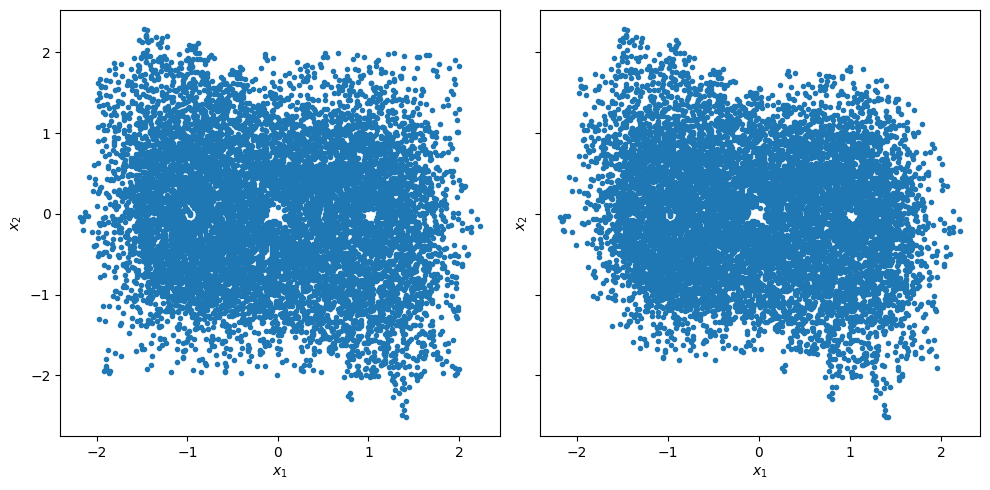

In [3]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=(10,5))
data_x_train = data_train.data()
ax1.plot(data_x_train[:,0], data_x_train[:,1], '.')
ax1.set_xlabel(r'$x_{1}$')
ax1.set_ylabel(r'$x_{2}$')
data_y_train = data_train.labels()
ax2.plot(data_y_train[:,0], data_y_train[:,1], '.')
ax2.set_xlabel(r'$x_{1}$')
ax2.set_ylabel(r'$x_{2}$')
plt.tight_layout()

Visualize validation data

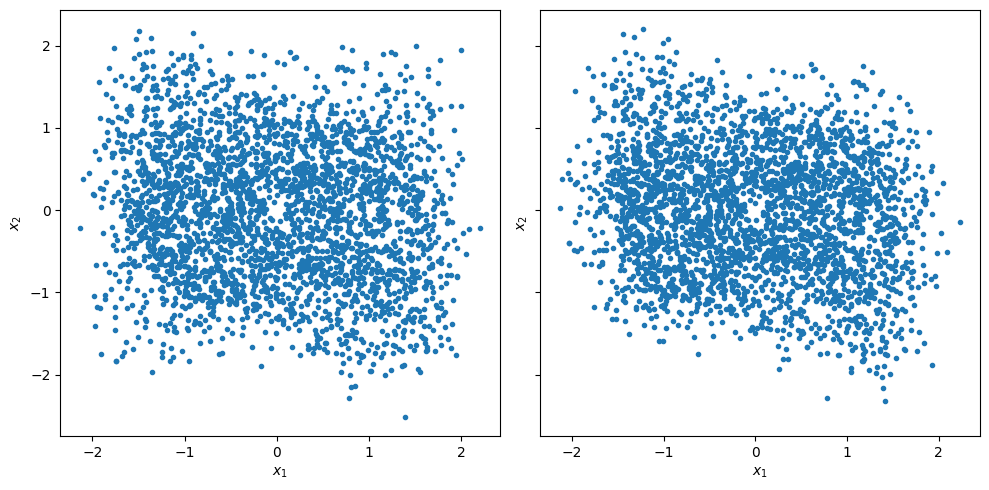

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=(10,5))
data_x_valid = data_valid.data()
ax1.plot(data_x_valid[:,0], data_x_valid[:,1], '.')
ax1.set_xlabel(r'$x_{1}$')
ax1.set_ylabel(r'$x_{2}$')
data_y_valid = data_valid.labels()
ax2.plot(data_y_valid[:,0], data_y_valid[:,1], '.')
ax2.set_xlabel(r'$x_{1}$')
ax2.set_ylabel(r'$x_{2}$')
plt.tight_layout()

Build up the solver

In [5]:
D = 2
M = 25
non_trainables = D + 1
hidden_layer_sizes = [100, 100, 100]
lr = 1e-4
reg = 0.1
reg_final = 0.01
n_epochs = 3000
batch_size = 5000


net = kdl.TanhResNetWithNonTrainable(D, M, hidden_layer_sizes, non_trainables)
opt = torch.optim.Adam(net.parameters(), lr)
dic = kdl.TrainableDictionary(M, net, opt)
solver = kdl.EDMDDLSolver(dic, reg)
solver.solve(data_x_train, data_y_train, n_epochs, batch_size)
K = solver.compute_K(data_x_train, data_y_train, reg_final)
solver.eig_decomp(K)

Training: 100%|██████████| 300/300 [01:30<00:00,  3.30it/s, loss=1.76e-05]


## Prediction

In [6]:
traj_len = 50
rbf_basis_func = kdl.RBFDictionary(100, 1e-4)
rbf_basis_func.build(data_x_train)
rbf_solver = kdl.EDMDSolver(rbf_basis_func)
K = rbf_solver.compute_K(data_x_train, data_y_train)
rbf_solver.eig_decomp(K)

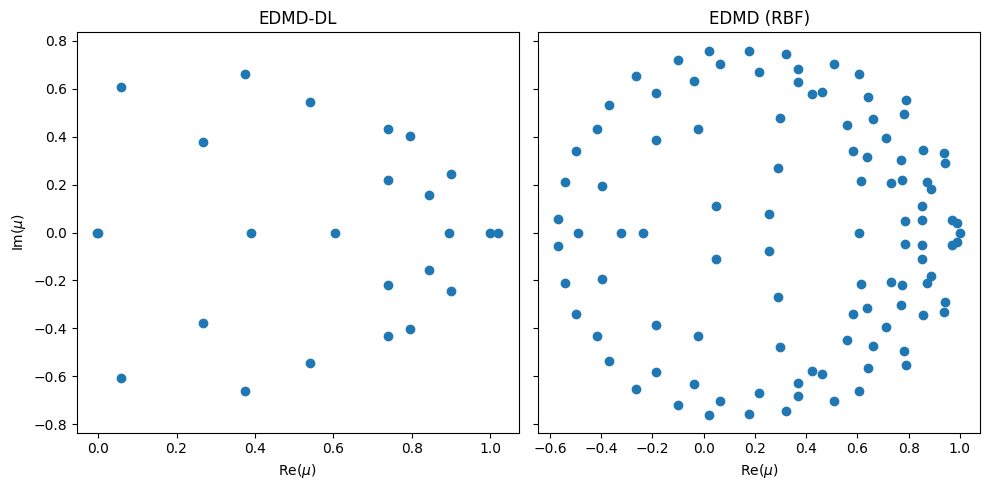

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=True)
ax1.scatter(solver.eigenvalues.real,solver.eigenvalues.imag)
ax1.set_xlabel(r'Re$(\mu)$')
ax1.set_ylabel(r'Im$(\mu)$')
ax1.set_title('EDMD-DL')

ax2.scatter(rbf_solver.eigenvalues.real, rbf_solver.eigenvalues.imag)
ax2.set_xlabel(r'Re$(\mu)$')
ax2.set_title('EDMD (RBF)')

fig.tight_layout()